In this exercise, I have implemented the following :
1. Horn and Schunck ME algorithm implementation and testing
2. Slightly improved GCE by smoothing the images
3. Track an earthworm's motion in a video with Harris corner points in a video
All implementations have been done from scratch and for most part I have not used any of the built-in functions except in few places (eg. Harris corner point detection) which are not in the scope of the assignment.
I also wanted to explore the kalman filter technique, but leaving that out as future exploration due to lack of time

In [ ]:
import numpy as np
import os
import cv2
from scipy import ndimage
import scipy
import time
from math import sqrt, cos, pi
import matplotlib 
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from scipy.signal import correlate2d
from scipy import signal

In [ ]:
class Motion_est:

    def __init__(self):
        self.track_len = 10
        self.detect_interval = 5
        self.tracks = []
        self.tracks_poly = []
        self.frame_idx = 0

    def plotflow(self, I, X, Y, U, V, scale=1, threshold=-1):
        fig, ax = plt.subplots(figsize=(10, 10), dpi=80)
        if threshold > 0:
            mask = np.abs(U + 1j*V) > threshold
            X = X[mask]
            Y = Y[mask]
            U = U[mask]
            V = V[mask]
            
        ax.imshow(I, cmap='gray')
        ax.quiver(X, Y, U*scale, V*scale, color='red', angles='xy', scale_units='xy', scale=1)
        ax.set_aspect('equal')
        plt.show()
        return   
    
    def cor_f(self, choice, path):
        Img1, Img2 = self.get_seq(choice, path)
        # change above to run through all consecutive frames also

        # now compute the image pyramid
        pyramid_imgs, num_levels = self.pyramid_gaussian(Img2)
        total_rows = 0
        total_cols = 0
        for i in range(int(num_levels)):
            r, c, dd = pyramid_imgs[i].shape
            total_rows += r
            total_cols += c
        # display the pyramid
        pyramid_stack = np.zeros((total_rows, total_cols, dd), dtype = np.uint16)
        i_row = 0
        for i in range(int(num_levels)):
            r, c, d = pyramid_imgs[i].shape
            if i==0:
                pyramid_stack[:r,:c,:d] = np.array(pyramid_imgs[i]).astype(np.uint16)
                fr=r
                fc=c
                continue
            pyramid_stack[i_row: i_row+r, fc:fc+c,:d] = np.array(pyramid_imgs[i]).astype(np.uint16)
            fc+= c
        cv2.imshow('ImagePyramid', pyramid_stack)
        cv2.waitKey(0)
        
        # now let's start working on block matching by correlation for motion estimation
        ref_im = cv2.cvtColor(Img1, cv2.COLOR_BGR2GRAY)
        h,w = ref_im.shape
        hstart, hend,wstart,wend = 0,0,0,0
        ws = 7 #match subblocks of size 7 x 7
        x=np.arange(0, w, ws)
        y=np.arange(0, h, ws)
        gridX, gridY = np.meshgrid(x,y)
        #print(gridX,gridY)
        H, W = gridX.shape # the height and width of output 
        U = np.zeros((H, W))
        V = np.zeros((H, W))
        for i in range(H):
            if hend+ws > h:
                hstart = h-ws
                hend = h
            else:
                hstart = hend
                hend += ws
            for j in range(W):
                if wend+ws > w:
                    wstart = w-ws
                    wend =w
                else:
                    wstart = wend
                    wend += ws
                sub_block = ref_im[hstart:hend, wstart:wend]
                ind={
                    'h':h,
                    'w':w,
                    'hstart':hstart,
                    'wstart':wstart,
                    'ws':ws,
                    }
                u,v = self.ncc_calc(int(num_levels), pyramid_imgs, ind, sub_block)
                U[i,j]=u
                V[i,j]=v
        # now call the routine to plot the motion vector:
        self.plotflow(ref_im, gridX, gridY, U, V, 1, 0.3)
        plt.hist(U.flatten())
        plt.hist(V.flatten())
        return

    def ncc_calc(self, num_levels, pyramid_imgs, ind, sub_block):
        r=2
        c=2
        ws = ind['ws']
        for l in range(num_levels):
            #print('level ', l)
            coarse_im = cv2.cvtColor(pyramid_imgs[(num_levels-1)-l], cv2.COLOR_BGR2GRAY)
            if l > 0:
                i_new = max((i-1)*(r-1)+i,0)
                j_new = max((j-1)*(c-1)+j,0)
                #print(i_new, j_new)
                rstart = max(i_new-ws,0)
                rend = min(i_new+ws,ind['h'])
                cstart = max(j_new-ws,0)
                cend = min(j_new+ws,ind['w'])
                coarse_im = coarse_im[rstart:rend, cstart:cend]
            block_norm = sub_block - np.mean(sub_block)
            block_norm /= (np.sum(block_norm**2))**0.5
            coarse_norm = coarse_im - np.mean(coarse_im)
            coarse_norm /= (np.sum(coarse_norm**2)**0.5)
            #print(coarse_norm.shape)
            ncc_output = correlate2d(coarse_norm, block_norm, 'same')
            i, j = np.unravel_index(ncc_output.argmax(),ncc_output.shape)
            # motion vector estimation
            if l==num_levels-1:
                #u = j_new - ind['h'] - ind['hstart'] + j
                #v = i_new - ind['w'] - ind['wstart'] + i
                #u = cstart - ind['wstart'] + j
                #v = rstart - ind['hstart'] + i
                u = cstart + j
                v = rstart + i
        return u,v

    def poc_f(self, choice, path):
        Img1, Img2 = self.get_seq(choice, path)
        ref_im = cv2.cvtColor(Img1, cv2.COLOR_BGR2GRAY)
        cur_im = cv2.cvtColor(Img2, cv2.COLOR_BGR2GRAY)
        h,w = ref_im.shape
        hstart, hend,wstart,wend = 0,0,0,0
        bs = 16
        x=np.arange(0, w, bs)
        y=np.arange(0, h, bs)
        gridX, gridY = np.meshgrid(x,y)
        H, W = gridX.shape # the height and width of output 
        U = np.zeros((H, W))
        V = np.zeros((H, W))
        for i in range(H):
            if hend+bs > h:
                hstart = h-bs
                hend = h
                hsc = h-2*bs
                hec = h
            else:
                hstart = hend
                hend += bs
                hsc = hstart-bs
                hec = hend+bs
            if hstart-bs < 0:
                hsc = 0
                hec = hend + 2*bs                
            for j in range(W):
                if wend+bs > w:
                    wstart = w-bs
                    wend =w
                    wsc = w - 2*bs
                    wec = w
                else:
                    wstart = wend
                    wend += bs
                    wsc = wstart - bs
                    wec = wend+bs
                if wstart-bs<0:
                    wsc = 0
                    wec = wend + 2*bs
                sub_block_r = ref_im[hstart:hend, wstart:wend]
                #sub_block_c = cur_im[hstart:hend, wstart:wend]
                sub_block_c = cur_im[hsc:hec, wsc:wec]
                u,v = self.poc_calc(sub_block_r, sub_block_c, hsc, wsc)
                U[i,j]=u
                V[i,j]=v
        # now call the routine to plot the motion vector:
        self.plotflow(ref_im, gridX, gridY, U, V, 1, 0.3)
        plt.hist(U.flatten())
        plt.hist(V.flatten())
        return

    def poc_calc(self, rim, cim, hstart, wstart):
        h, w = rim.shape
        hc, wc = cim.shape
        bs = 16
        hsc, hec, wsc, wec = 0, 0, 0, 0
        hc_check, wc_check = True, True
        temp_max = []
        u_temp,v_temp = [], []
        for i in range(hc):
            if hc_check == False:
                continue
            if hsc+bs > hc:
                hsc = hc-bs
                hec = hc
                hc_check = False
            else:
                hsc += 1
                hec = hsc + bs
            for j in range(wc):
                if wc_check == False:
                    continue
                if wec+bs > wc:
                    wsc = wc-bs
                    wec = wc
                    wc_check = False
                else:
                    wsc += 1
                    wec = wsc + bs
                #print(cim.shape)
                cim_sub = cim[hsc:hec, wsc:wec]
                #print(hsc, hec, wsc, wec)
                #print(cim_sub.shape)
                hanning = [np.hanning(h), np.hanning(w)]
                window = hanning[1].reshape(hanning[1].shape[0],1)*hanning[0]
                #print(window.shape)
                rim1 = np.float64(rim)*window
                cim1 = np.float64(cim_sub)*window
                fft_im1 = np.fft.fft2(rim1)
                fft_im2 = np.fft.fft2(cim1)
                cross_power = fft_im1 * np.ma.conjugate(fft_im2)
                #cross_power = fft_im1 * np.conjugate(fft_im2)/np.absolute(fft_im1*np.conjugate(fft_im2))
                cross_power/= np.absolute(cross_power)
                ncc_output = np.real(np.fft.ifft2(cross_power))
                i, j = np.unravel_index(ncc_output.argmax(),ncc_output.shape)
                u = wsc+j
                v = hsc+i
                temp_max.append(ncc_output[i,j])
                u_temp.append(u)
                v_temp.append(v)
        max_ind = np.argmax(temp_max)
        u = u_temp[max_ind]
        v = v_temp[max_ind]
        return u, v

    def gradient_xyt(self, I1, I2, x, y):
        h, w = I1.shape
        x = int(x)
        y = int(y)
        
        Ix = (x>0 and x< (w-1) and y>=0 and y<h ) and (I1[y, x+1] - I1[y, x-1])/2 or 0
        Iy = (x>=0 and x<w and y>0 and y< (h-1) ) and (I1[y+1, x] - I1[y-1, x])/2 or 0
        It = (x>=0 and x<w and y>=0 and y<h) and I2[y,x] - I1[y,x] or 0
        return (Ix, Iy, It)

    def getAb(self, I1, I2, x, y, n):
        A = np.zeros((n*n, 2))
        b = np.zeros(n*n)
        
        # compute the relative positions of pixels in a window
        offset = np.arange(0, n) - np.floor(n/2); 
        dx, dy = np.meshgrid(offset, offset);
        dx = dx.reshape(n*n, 1);
        dy = dy.reshape(n*n, 1);
        
        # compute the elements of A and b
        for i in range(0, n*n):
            Ix, Iy, It = self.gradient_xyt(I1, I2, x+dx[i], y+dy[i])
            A[i, 0] = Ix 
            A[i, 1] = Iy
            b[i] = -It
            
        return (A, b)

    ##  flow->motion
    def estimate_flow_at_xy(self, I1, I2, x, y, n):
        A, b = self.getAb(I1, I2, x, y, n)
     
        # least square 
        # https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.lstsq.html  
        result = np.linalg.lstsq(np.matmul(A.T, A), np.matmul(A.T, b))
        # result = np.linalg.lstsq(A, b)
        v = result[0]
        return v

    def estimate_flow(self, I1, I2, gridX, gridY, n):
        H, W = gridX.shape # the height and width of output 
        U = np.zeros((H, W))
        V = np.zeros((H, W))
        
        # iterate over the grid
        for i in range(0, H):
            for j in range(0, W):
                v =  self.estimate_flow_at_xy(I1, I2,gridX[i, j], gridY[i, j], n)
                U[i, j] = v[0]
                V[i, j] = v[1]
        return (U, V)

    def kl_f(self, choice, path):
        Img1, Img2 = self.get_seq(choice, path)
        #Img1 = cv2.cvtColor(Img1, cv2.COLOR_BGR2GRAY)
        #Img2 = cv2.cvtColor(Img2, cv2.COLOR_BGR2GRAY)
        Img1 = self.gaussian_blur(cv2.cvtColor(Img1, cv2.COLOR_BGR2GRAY))
        Img2 = self.gaussian_blur(cv2.cvtColor(Img2, cv2.COLOR_BGR2GRAY))
        H, W = Img1.shape
        gridsz = 9
        wsz  = 21
        x = np.arange(0, W-gridsz, gridsz) + np.floor(gridsz/2);
        y = np.arange(0, H-gridsz, gridsz) + np.floor(gridsz/2);
        gridX, gridY = np.meshgrid(x,y);
        U, V = self.estimate_flow(Img1, Img2, gridX, gridY, wsz)
        self.plotflow(Img1, gridX, gridY, U, V, 1, 5)
        return


    def hs_f(self, choice, path):
        Img1, Img2 = self.get_seq(choice, path)
        Img1 = self.gaussian_blur(cv2.cvtColor(Img1, cv2.COLOR_BGR2GRAY)).astype(np.float)
        Img2 = self.gaussian_blur(cv2.cvtColor(Img2, cv2.COLOR_BGR2GRAY)).astype(np.float)
        num_iter = 100
        reg_const = 1
        h, w = Img1.shape
        U = np.zeros((h,w))
        V = np.zeros((h,w))
        
        Ix, Iy, It = self.gradient_hs(Img1, Img2)
        fs = np.array([[1/12,1/6,1/12],[1/6,0,1/6],[1/12,1/6,1/12]], dtype = float)
        for i in range(num_iter):
            u_bar = cv2.filter2D(U, -1, fs)
            v_bar = cv2.filter2D(V, -1, fs)
            U = u_bar - Ix*((Ix*u_bar + Iy*v_bar + It)/(reg_const**2+Ix**2+Iy**2))
            V = v_bar - Iy*((Ix*u_bar + Iy*v_bar + It)/(reg_const**2+Ix**2+Iy**2))
        ws = 5
        x=np.arange(0, w, ws)
        y=np.arange(0, h, ws)
        gridX, gridY = np.meshgrid(x,y)
        g_x_s, g_y_s = gridX.shape
        U_plot = np.zeros((g_x_s, g_y_s))
        V_plot = np.zeros((g_x_s, g_y_s))
        jc, kc = 0, 0
        for j in range(0, len(U), ws):
            kc = 0
            for k in range(0, len(V), ws):
                U_plot[jc, kc] = U[j,k]
                V_plot[jc, kc] = V[j,k]
                kc += 1
            jc+=1
        self.plotflow(Img1, gridX, gridY, np.array(U_plot), np.array(V_plot), 1, 0.3) # for worm, set threshold to 5
        return

    def gradient_hs(self, Img1, Img2):
        k_x = np.array([[-1/4, 1/4],[-1/4, 1/4]], dtype = float)
        k_y = np.array([[-1/4, -1/4],[1/4, 1/4]], dtype = float)
        k_t = np.array([[1/4, 1/4],[1/4, 1/4]], dtype = float)
        #Ix = cv2.filter2D(Img1,-1,k_x)+cv2.filter2D(Img2,-1,k_x)
        #Iy = cv2.filter2D(Img1,-1,k_y)+cv2.filter2D(Img2,-1,k_y)
        #It = cv2.filter2D(Img1,-1,k_t)-cv2.filter2D(Img2,-1,k_t)
        Ix = signal.convolve2d(Img1, k_x, 'same')+signal.convolve2d(Img2,k_x, 'same')
        Iy = signal.convolve2d(Img1, k_y, 'same')+signal.convolve2d(Img2,k_y, 'same')
        It = signal.convolve2d(Img1, k_t, 'same')-signal.convolve2d(Img2,k_t, 'same')
        return Ix, Iy, It

    def klt_track(self, choice, path):
        img_folder, fname_ip = self.get_seq(choice, path)
        vcapt = cv2.VideoCapture(img_folder + fname_ip)
        frame_width = int(vcapt.get(3))
        frame_height = int(vcapt.get(4))
        out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
        if (vcapt.isOpened()== False):
            print("Error opening video stream or file")
        while(vcapt.isOpened()):
            ret, frame = vcapt.read()
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            vis = frame.copy()
            print('Frame: ', self.frame_idx)
            if len(self.tracks) > 0:
                img0, img1 = self.prev_gray, frame_gray
                p0 = np.float32([tr[-1] for tr in self.tracks]).reshape(-1, 1, 2)
                p1 = self.hs_track_point(img0, img1, p0)
                #print('returned p1')
                '''p0r = self.hs_track_point(img1, img0, p1)
                print('returned p0r')
                d = abs(p0-p0r).reshape(-1, 2).max(-1)
                print(d)
                good = d < 1'''
                new_tracks = []
                new_tracks_poly = []
                '''for tr, (x, y), good_flag in zip(self.tracks, p1.reshape(-1, 2), good):
                    if not good_flag:
                        continue'''
                for tr, tr_poly, (x, y) in zip(self.tracks, self.tracks_poly, p1.reshape(-1, 2)):
                    tr.append((x, y))
                    tr_poly.append((y,x))
                    if len(tr) > self.track_len:
                        del tr[0]
                        del tr_poly[0]
                    new_tracks.append(tr)
                    new_tracks_poly.append(tr_poly)
                    cv2.circle(vis, (int(y), int(x)), 2, (0, 255, 0), -1)
                self.tracks = new_tracks
                self.tracks_poly = new_tracks_poly
                cv2.polylines(vis, [np.int32(tr) for tr in self.tracks_poly], False, (0, 255, 0))
                #cv2.polylines(vis, [np.int32(tr) for tr in self.tracks], False, (0, 255, 0))
                #draw_str(vis, (20, 20), 'track count: %d' % len(self.tracks))
                
            if self.frame_idx % self.detect_interval == 0:
                p = cv2.cornerHarris(frame_gray,2,3,0.04)
                #vis[p>0.01*p.max()]=[0,255,0]
                pf = np.where(p>0.01*p.max())
                pf_list = list(zip(*pf))
                if pf_list is not None:
                    #for x, y in np.float32(pf).reshape(-1, 2):
                        #print(x,y)
                    for x,y in pf_list:
                        self.tracks.append([(x, y)])
                        self.tracks_poly.append([(y,x)])
                        # to display the corner points
                        #cv2.imshow('vis', vis)

            '''if self.frame_idx % self.detect_interval == 0:
                mask = np.zeros_like(frame_gray)
                mask[:] = 255
                for x, y in [np.int32(tr[-1]) for tr in self.tracks]:
                    cv2.circle(mask, (x, y), 5, 0, -1)
                p = cv2.goodFeaturesToTrack(frame_gray, mask = mask, **feature_params)
                if p is not None:
                    for x, y in np.float32(p).reshape(-1, 2):
                        self.tracks.append([(x, y)])'''
            
            self.prev_gray = frame_gray
            cv2.imshow('lk_track', vis)
            out.write(vis)
            self.frame_idx += 1

            ch = cv2.waitKey(1)
            if ch == 27:
                break
        return

    def hs_track_point(self, Img1, Img2, p):
        Img1 = self.gaussian_blur(Img1).astype(np.float)
        Img2 = self.gaussian_blur(Img2).astype(np.float)
        num_iter = 10
        reg_const = 1
        h, w = Img1.shape
        U = np.zeros((h,w))
        V = np.zeros((h,w))
        
        Ix, Iy, It = self.gradient_hs(Img1, Img2)
        fs = np.array([[1/12,1/6,1/12],[1/6,0,1/6],[1/12,1/6,1/12]], dtype = float)
        for i in range(num_iter):
            u_bar = cv2.filter2D(U, -1, fs)
            v_bar = cv2.filter2D(V, -1, fs)
            U = u_bar - Ix*((Ix*u_bar + Iy*v_bar + It)/(reg_const**2+Ix**2+Iy**2))
            V = v_bar - Iy*((Ix*u_bar + Iy*v_bar + It)/(reg_const**2+Ix**2+Iy**2))
        UV = []
        jc = 0
        for pt in range(len(p)):
            xpt, ypt = p[pt][0]
            xpt = min(xpt, h-1)
            ypt = min(ypt, w-1)
            UV.append([(int(xpt)+V[int(xpt), int(ypt)],int(ypt)+U[int(xpt),int(ypt)])])
            #UV.append([(int(ypt)+U[int(xpt),int(ypt)],int(xpt)+V[int(xpt), int(ypt)])])
        return np.array(UV)
    
    def kal_track(self, choice, path):
        Img1, Img2 = self.get_seq(choice, path)
        pass

    def normalize_fn(self, choice, path):
        pass

    def gaussian_blur(self, img):
        fs = 3
        Img_final = cv2.GaussianBlur(img, (fs,fs),0)
        Img2 = Img_final.astype(np.uint8)
        return Img_final

    def remove_r_c(self, img):
        return img[::2,::2,:]

    def pyramid_gaussian(self, img):
        num_levels = input('Enter the number of levels in the pyramid: ')
        pyramid_img = [img]
        for l in range(int(num_levels)-1):
            img = self.gaussian_blur(img)
            img = self.remove_r_c(img)
            print(img.shape)
            pyramid_img.append(img)
        return pyramid_img, num_levels

    def plot_hist(self):
        pass
    
    def plot_motion(self):
        pass

    def video_to_frames(self, filename, path):
        directory = os.fsencode(path)
        vcapt = cv2.VideoCapture(path + filename)
        captured, frame = vcapt.read()
        count = 0
        captured = True
        while captured:
            cv2.imwrite(os.path.join(path,"frame%d.jpg" % count), frame)
            success,frame = vcapt.read()
            count += 1
        return
    
    def get_seq(self, choice, img_folder):
        directory = os.fsencode(img_folder)
        vid = input('Convert video to seq images ? enter y or n: ')
        if vid == 'y':
            fname_ip = input('Enter the name of the video file: ')
            for file in os.listdir(img_folder):
                filename = os.fsdecode(file)
                if not (fname_ip == filename):
                    continue
                self.video_to_frames(filename,img_folder)
                break
        # now get the two sequences to plot motion vector
        if choice == 'klt_track' or choice == 'kal_track':
                if vid == 'n':
                    fname_ip = input('Enter the name of the video file: ')
                print('Showing input video')
                vcapt = cv2.VideoCapture(img_folder + fname_ip)
                if (vcapt.isOpened()== False):
                    print("Error opening video stream or file")
                while(vcapt.isOpened()):
                    ret, frame = vcapt.read()
                    if ret == True:
                        cv2.imshow('Frame',frame)
                        if cv2.waitKey(25) & 0xFF == ord('e'):
                            break
                    else:
                        break
                vcapt.release()
                return img_folder, fname_ip
        else:
                ip1 = input('Enter the name of the reference image: ')
                ip2 = input('Enter the name of the current image: ')
                if os.fsencode(ip1) not in os.listdir(directory) or os.fsencode(ip2) not in os.listdir(directory):
                    print('wrong input file name')
                    return
                Img1 = self.read_image(img_folder, ip1)
                Img2 = self.read_image(img_folder, ip2)
                if Img1 is None or Img2 is None:
                    print('Input image is None, returning')
                    return
                cv2.namedWindow('Reference Image')
                cv2.imshow('Reference Image', Img1)
                cv2.namedWindow('Current Image')
                cv2.imshow('Current Image', Img2)
                cv2.waitKey(0)
                return Img1, Img2
            
    def read_image(self, directory, filename):
        #if filename.startswith("f") and (filename.endswith(".jpg") or filename.endswith(".bmp") or filename.endswith(".png") or filename.endswith(".gif")):
        if (filename.endswith(".jpg") or filename.endswith(".bmp") or filename.endswith(".png") or filename.endswith(".gif")):
            print(filename)
            img = cv2.imread(directory + filename,-1)
            if img is None:
                print('Invalid image:' + filename)
                return None
            return img

    def main(self, choice, path):
        options = {'cor_f':self.cor_f,
                   'poc_f':self.poc_f,
                   'kl_f': self.kl_f,
                   'hs_f': self.hs_f,
                   'klt_track':self.klt_track,
                   'kal_track':self.kal_track,
            }
        options[choice](choice, path)
        return


In [ ]:
if __name__ == "__main__":

    # creating an instance of the motion estimation class
    me_class = Motion_est()

    # Call to the main function
    tic = time.time()
    print('Choices are : \n 1. Correlation(cor_f) \n 2. Phase Correlation (poc_f) \n 3. Lucas Kanade (kl_f) \n 4. Horn&Schunck (hs_f) \n 5. KLT tracker (klt_track) and \n 6. Kalman+Hanning(kal_track)')
    choice_v = input("Enter the choice: ")
    path = input("Enter the folder to the seq or video: ")
    # for path enter ..\\input\\
    me_class.main(choice_v, path)
    toc = time.time() - tic
    print("Running time: " + str(toc))

Referenced quote - Following Horn’s taxonomy, the motion field is the 2D projection of the 3D motion of surfaces in the world, whereas the optical flow is the apparent motion of the brightness patterns in the image.

## Horn & Schunck Algorithm :
For implementing this algorithm, I used the following two articles as reference to understand the algorithm and then implemented it from scratch :
http://www.journal.au.edu/au_techno/2011/july2011/journal151_article02.pdf
https://en.wikipedia.org/wiki/Horn%E2%80%93Schunck_method

As listed in wikipedia, the optical flow computation by Horn and schunck involves the following steps :
1. Smooth the two image sequences
2. Compute the gradients, I used the following kernel for Ix, Iy and It :
        k_x = np.array([[-1/4, 1/4],[-1/4, 1/4]])
        k_y = np.array([[-1/4, -1/4],[1/4, 1/4]])
        k_t = np.array([[1/4, 1/4],[1/4, 1/4]])
        Ix = conv(Im1, k_x) + conv(Im2, k_y)
        Iy = conv(Im1, k_y) + conv(Im2, k_y)
        It = conv(Im1, k_t) - conv(Im2, k_t)
3. After obtaining the gradients, I find the local weighted average of the neighborhood using a filter kernel. 
4. Finally the motion vector is updated using the following equations :

![Alt text](imgs/hs_formula.png?raw=true "I1_box")

This algorithm is iterative, so higher the number of iterations and larger the value of regularization constant, I observed that the results are better.

For the sphere, the algorithm produced great results :

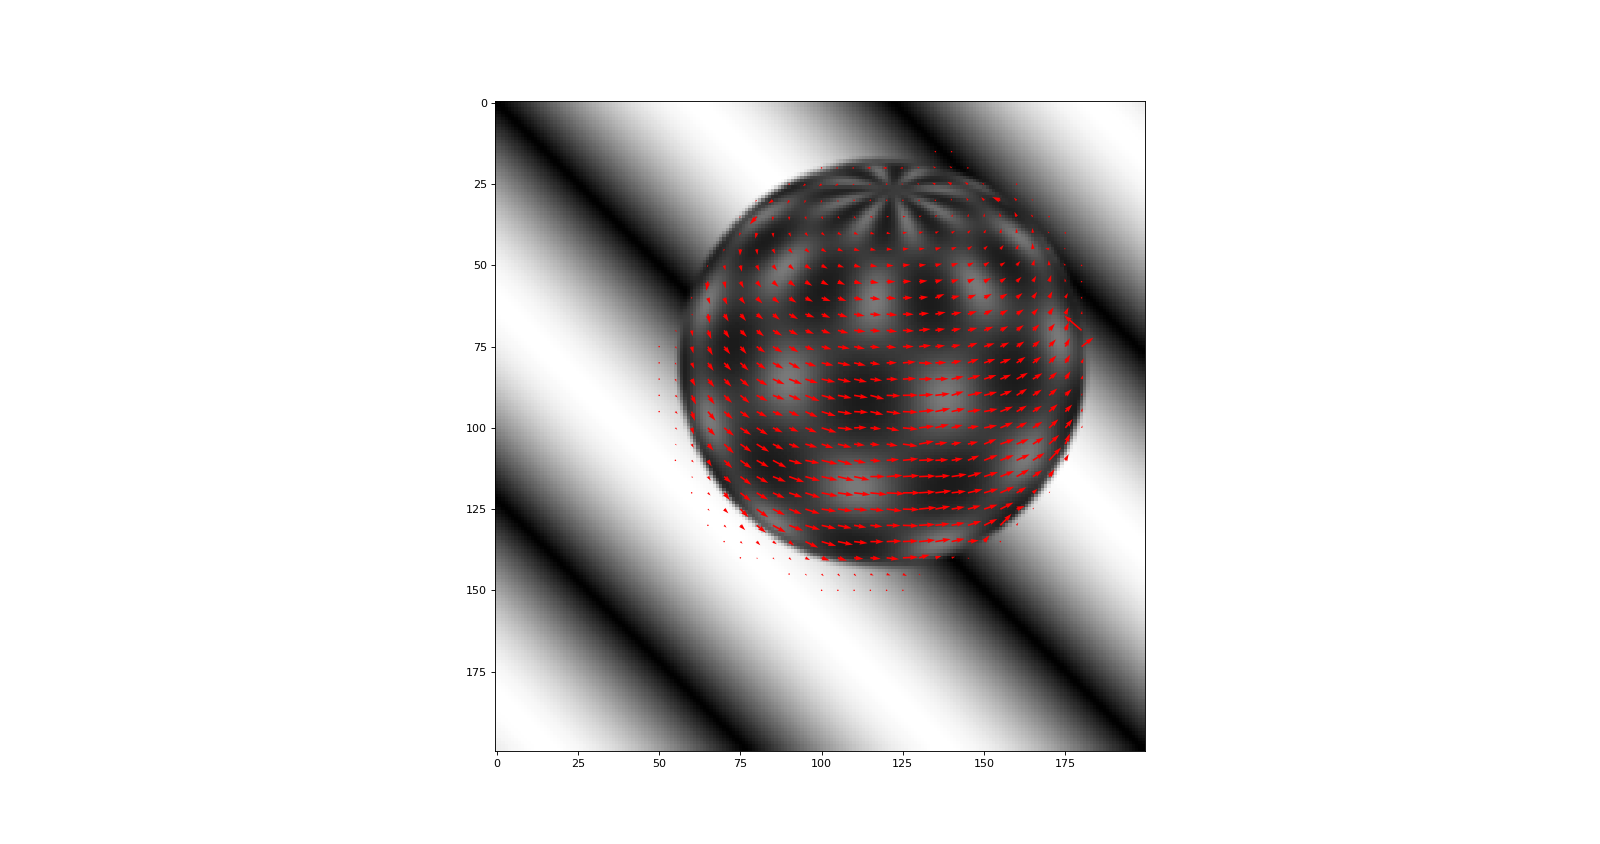

This is just with 100 iterations.

![Alt text](imgs/HS_Worm_Correct2.png?raw=true "HS_Worm_Correct2")

![Alt text](imgs/HS_Seq_Correct.png?raw=true "HS_Seq_Correct")

Above is the result of the HS algorithm for the sequence image. The motion vector looks good though there are noisy vectors, the other areas look good.

I also had some videos of an earthworm moving around in a white background from a previous project I worked with the Bio robotics team, was interested in testing out the algorithm on the earthworm sequences and here is the result: 

Old Image : (frame10.jpg)

![Alt text](imgs/frame10.jpg?raw=true "frame10")

Current image: (frame18.jpg)

![Alt text](imgs/frame18.jpg?raw=true "frame18")

Here is the motion vector estimated by the HS algorithm :
![Alt text](imgs/HS_Worm_Correct.png?raw=true "HS_Worm_Correct")

Even when the motion between the two sequence images was large, the algorithm was able to identify the motion decently. For eg., when reference image was the 'frame10' image and I used the below frame783 image as current image,

![Alt text](imgs/frame783.jpg?raw=true "frame783")

As we can see from the results, though there is noise, for majority part, the motion vector has the right magnitude and orientation.
![Alt text](imgs/HS_Worm_Correct_frame10_frame783.png?raw=true "HS_Worm_Correct_frame10_frame783")

The given gradient constraint solution (Lucas-Kanade) provided in the demo did not do a great job. But this method with some improvements will definitely provide good motion vector estimates.
Result from demo GCE solution (Lucas Kanade):
![Alt text](imgs/KL_smoothed_no.png?raw=true "KL_smoothed_no")

## Earthworm Tracking :
The above implementation motivated me to track the corner points of the earthworm through the video and hence I extended the HS algorithm to track selective points. The points in this case are the corner points detected by harris corner detectors.

Here is the tracking video :

<video controls src="../imgs/outpy.avi"/>

If the video does not play here, please do check the output directory, have included the video here. The tracking is not perfect but it works decently with just a basic implementation of the Horn and Schunck algorithm. This is promising, finding better ways to improve this algorithm (eg. using pyramids, etc) should improve the tracking results.